<a href="https://colab.research.google.com/github/StephenJudeD/Generative-AI-Advanced-RAG-Model-using-Orwells-1984/blob/main/1984_advanced_rag_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative AI: Building Retrieval Augmented Generation (RAG) Models using Orwell's 1984

This notebook demonstrates how to build a RAG model (Retrieval Augmented Generation) for answering a user’s question about 1984 (knowledges base) using LangChain.

## Install Dependencies

In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 2.2 M

In [2]:
from google.colab import drive  # Library for Google Drive integration

# Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load & Preprocess George Orwells 1984

In [3]:
# Read the entire file at once
with open('/content/drive/MyDrive/1984/1984.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
import re

def preprocess_1984_from_text(text):
    chapters = []
    current_part = None
    chapter_title = None
    chapter_text = []

    for line in text.splitlines():
        line = line.strip()

        # Detect part heading (unmodified)
        part_match = re.match(r"PART (\w+)", line)
        if part_match:
            current_part = part_match.group(1)

        # Detect chapter titles with numbers only
        chapter_match = re.match(r"^Chapter (\d+)$", line)
        if chapter_match:
            # Store previous chapter (if any)
            if chapter_title:
                chapters.append({
                    "part": current_part,
                    "title": chapter_title,
                    "text": ' '.join(chapter_text)
                })

            chapter_title = "Chapter " + chapter_match.group(1).strip()
            chapter_text = []

        else:  # It's regular text content
            chapter_text.append(line)

    # Store the last chapter
    if chapter_title:
        chapters.append({
            "part": current_part,
            "title": chapter_title,
            "text": ' '.join(chapter_text)
        })

    return chapters

In [5]:
# How to use it with the existing setup
processed_chapters = preprocess_1984_from_text(text)

In [1]:
#for chapter in processed_chapters:
    #print(f"PART {chapter['part']}")  # Print PART heading
    #print(chapter['title'])
    #print(chapter['text'])
    #print("-----------------")  # Separator between chapters


In [7]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

### Load the knowledge base

In [8]:
from langchain.docstore.document import Document as LangchainDocument

In [9]:
# Create 'raw_knowledge' with LangchainDocument objects
raw_knowledge_base = []
for chapter in processed_chapters:
    doc = LangchainDocument(
        page_content=chapter['text'],
        metadata={
            "source": "1984",  # Indicate that the source is the book "1984"
            "part": chapter['part'],
            "title": chapter['title']
        }
    )
    raw_knowledge_base.append(doc)

## Retriever - Embeddings

The retriever acts like an internal search engine for the '1984' knowledge base. Given a user's query, it finds the most relevant portions of the text. These snippets serve as the foundation for the Reader Model's comprehensive answer.

'1984' text is broken down into smaller chunks. These chunks are what the Reader Model will analyze to generate its answer. The text is split using overlapping chunks based on a desired size. This approach can be effective in ensuring ideas are not abruptly cut between chunks, and allows for some flexibility in the length of the resulting snippets.

In [10]:
# Text splitting logic
def split_text(text, chunk_size=1000, chunk_overlap=100):
    """Splits text into chunks with the desired size and overlap."""
    chunks = []
    start_index = 0
    while start_index < len(text):
        end_index = min(start_index + chunk_size, len(text))
        chunk = text[start_index:end_index]
        chunks.append(chunk)
        start_index += chunk_size - chunk_overlap
    return chunks

# Split documents in raw_knowledge_base
docs_processed = []
for doc in raw_knowledge_base:
    chunks = split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        new_doc = LangchainDocument(
            page_content=chunk,
            metadata={
                **doc.metadata,  # Keep the original metadata
                "chunk_index": i  # Add chunk index
            }
        )
        docs_processed.append(new_doc)

Token Lengths:
* In natural language processing (NLP), a token refers to a unit of text, such as a word or subword. Tokenization involves breaking down a sentence or document into these smaller units.
* The code calculates the lengths of tokens in a set of processed documents. Specifically, it computes the number of tokens in each document.


Purpose:
Understanding the distribution of token lengths is important for several reasons:
* Model Input Constraints: Many NLP models have a maximum input length (measured in tokens). If a document exceeds this limit, it must be truncated or split.
* Efficiency: Longer documents require more computational resources during training and inference.
Data Exploration: Analyzing token lengths helps researchers understand the characteristics of their text data.

Code Explanation:

The code below performs the following steps:
* Initializes a tokenizer using the pretrained model “thenlper/gte-small”.
* Computes the token lengths for each document in the docs_processed list.
* Creates a histogram to visualize the distribution of token lengths.

Histogram:
The histogram shows the frequency of different token lengths. It helps identify patterns, such as whether most documents are short or long.
The x-axis represents token lengths, and the y-axis represents the number of documents with that length.

In [11]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer


# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-large').max_seq_length}"
)

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-large") #https://huggingface.co/thenlper
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/664 [00:00<?, ?it/s]

In [12]:
import os

# Google Drive setup
drive_path = "/content/drive/MyDrive/1984/"  # Update with the correct path
output_filename = "processed_docs.txt"       # Choose a desired filename

# Save the data
with open(os.path.join(drive_path, output_filename), "w") as f:
    for doc in docs_processed:
        # Assuming each 'doc' is a string or has the text you want to save
        f.write(str(doc) + "\n")  # Write the document followed by a newline

print("Processed documents saved to:", os.path.join(drive_path, output_filename))

Processed documents saved to: /content/drive/MyDrive/1984/processed_docs.txt


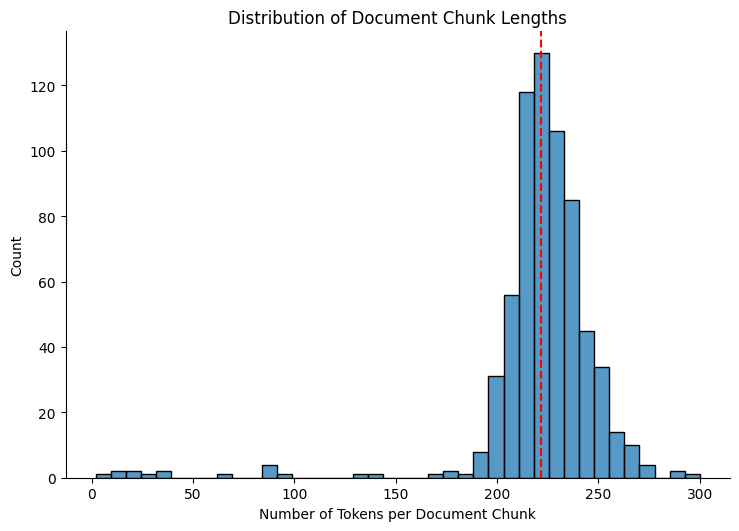

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.displot(lengths, kind='hist', bins=40, kde=False, aspect=1.5)
plt.xlabel("Number of Tokens per Document Chunk")
plt.title("Distribution of Document Chunk Lengths")
plt.axvline(x=np.mean(lengths), color='red', linestyle='dashed')
plt.show()

detailed analysis of the distribution

* Peaked Triangle Distribution:  The histogram has a triangular shape with a peak around 225 tokens. This suggests that most of the document chunks are clustered around this length, with a smaller number of chunks that are shorter or longer.

* Chunk Size Influence: The peak at 225 tokens  reflects the size of text chunks created during the text-splitting stage in the code. If the chunk size was set to 1000 tokens with an overlap of 100 tokens, then this would explain the peak at 225 tokens (which is likely the most frequent chunk size after accounting for overlap).

* Limited Lengths: The fact that the distribution tails off to the left and right suggests that there's a limit on the document lengths in the knowledge base. There aren't many documents that are much shorter than 190 tokens (5 bins to the left of the peak) or much longer than 275 tokens (8 bins to the right of the peak).

Overall, this distribution seems well-suited for a system that retrieves information from short, well-defined chunks of text. The majority of chunks fall within a predictable range, allowing for efficient retrieval.

## Building the Vector Database

Embedding the Knowledge Base: To represent our knowledge base in a way that lets us search it semantically, we compute embeddings (numerical representations) for all the text chunks.

How Retrieval Works

* Query Embedding: When a user enters a query, we use the same embedding model to convert it into an embedding vector.
* Similarity Search:  We use a vector database to find the document chunks in our knowledge base that are most similar to the query's embedding.

This involves:

* FAISS: We'll employ Facebook's FAISS library (github: https://github.com/facebookresearch/faiss) for fast similarity search within large datasets.
* Cosine Similarity: We'll measure the similarity between embeddings using cosine similarity, which aligns well with our chosen embedding model.

Key Points:

* Normalization: We normalize embeddings to ensure cosine similarity compares them based on direction rather than magnitude.
* Efficiency: FAISS is optimized for rapid similarity searches, making the retrieval process fast.

In [14]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

sentence_transformer = "thenlper/gte-large"

embedding_model = HuggingFaceEmbeddings(
    model_name=sentence_transformer,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

document_vector_store = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [15]:
# embed a user query in the same space
user_query = "Describe Big Brother?"
query_vector = embedding_model.embed_query(user_query)

In [19]:
#docs_processed

In [17]:
print(f"\nStarting retrieval for query: {user_query}")

retrieved_docs = document_vector_store.similarity_search(query=user_query, k=5)

print("\n--- Top Matching Document ---")
print(retrieved_docs[0].page_content)
print("\n--- Document Metadata ---")
print(retrieved_docs[0].metadata)


Starting retrieval for query: Describe Big Brother?

--- Top Matching Document ---
 IS PEACE FREEDOM IS SLAVERY IGNORANCE IS STRENGTH   But the face of Big Brother seemed to persist for several seconds on the screen, as though the impact that it had made on everyone's eyeballs was too vivid to wear off immediately. The little sandy-haired woman had flung herself forward over the back of the chair in front of her. With a tremulous murmur that sounded like 'My Saviour!' she extended her arms towards the screen. Then she buried her face in her hands. It was apparent that she was uttering a prayer.  At this moment the entire group of people broke into a deep, slow, rhythmical chant of 'B-B!...B-B!'--over and over again, very slowly, with a long pause between the first 'B' and the second--a heavy, murmurous sound, somehow curiously savage, in the background of which one seemed to hear the stamp of naked feet and the throbbing of tom-toms. For perhaps as much as thirty seconds they kept it 

## The Reader: Translating Retrieved Text into an Answer

In this part of the system, the Reader model has several important tasks:

* Processing Retrieved Information: The system gathers relevant documents (the 'context') based on the user's query. The Reader processes and potentially compresses these documents to create a manageable input for the next step.

* Crafting a Precise Prompt: The Reader combines the processed context with the user's original query into a well-structured prompt. This prompt guides the language model's answer generation.

* Generating the Answer: The  Reader uses a powerful language model (HuggingFaceH4/zephyr-7b-beta: https://huggingface.co/HuggingFaceH4/zephyr-7b-beta in the below example) to generate a text-based answer that addresses the user's query.

Code Explanation

* reader_model: Specifies the language model used by the Reader. For performance, it can be valuable to experiment with smaller or quantized models.
* BitsAndBytesConfig: Configures quantization, which can dramatically speed up inference by reducing the model's memory footprint.
* AutoModelForCausalLM.from_pretrained(...): Loads the language model, applying the quantization configuration for efficiency.
* AutoTokenizer.from_pretrained(...): Loads the matching tokenizer, ensuring the text input is correctly formatted for the language model.
pipeline(...): Creates the reader pipeline, encapsulating the model, tokenizer, and generation parameters. This provides a simple interface for generating answers based on new queries.

Why is the Reader Important?

* Contextualization: The Reader enables the system to use the most relevant knowledge to answer the user's query, rather than relying on the language model's general knowledge alone.
* Focused Generation: The Reader crafts a prompt that guides the language model towards the specific answer the user is seeking.

In [23]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

reader_model = "HuggingFaceH4/zephyr-7b-beta" #works well also
#reader_model="HuggingFaceH4/zephyr-7b-gemma-v0.1"


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    reader_model, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(reader_model)

llm_reader= pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.5,#Controls randomness in the generated text, higher temperature in text generation models leads to more creative and unpredictable output
    repetition_penalty=1.1,#enalizes the model for repeating phrases or sequences too often.
    return_full_text=False,#Specifies whether to return the full generated text including the input prompt.
    max_new_tokens=500,#Limits the maximum number of tokens (roughly words or word pieces) the model can generate
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [24]:
llm_reader("Tell me the number of legs a spider has:")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '\n\n1. 0 (false)\n2. 4 (true)\n3. 6 (false)\n4. 8 (false)\n\nThis quiz includes multiple choice questions with four options, and each question is accompanied by an image to make it more engaging. The correct answer will be highlighted in green, while the incorrect answers will be marked in red. At the end of the quiz, users will receive their quiz score and be able to share it on social media or challenge others to take the quiz.\n\nTo make the quiz more challenging, you can add bonus points for answering all questions correctly within a specific time limit. This feature will encourage users to answer quickly and accurately.\n\nAdditionally, you can include a leaderboard that displays the top scorers and their scores. This feature will create healthy competition among users and motivate them to perform better each time they take the quiz.\n\nOverall, this quiz will provide users with an enjoyable and educational experience while testing their knowledge about animal

Why Riddles?

* Question and Answer Structure: The model likely learned to associate the question-like format with riddles or similar quiz content from its training data.
* Informational vs. Creative: Riddles require factual knowledge combined with wordplay, which aligns with what a large language model might be good at.

## Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [25]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the provided context from '1984', answer the question directly and concisely. If the question cannot be answered from the provided context, indicate so directly"""
    },
    {
        "role": "user",
        "content": """Context (limit to ~2000 tokens):
{context}
---
Question: {question}""",
    },
]
prompt_template_rag = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(prompt_template_rag)

<|system|>
Using the provided context from '1984', answer the question directly and concisely. If the question cannot be answered from the provided context, indicate so directly</s>
<|user|>
Context (limit to ~2000 tokens):
{context}
---
Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

In [26]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = prompt_template_rag.format(
    question="what is freedom", context=context
)

# Redact an answer
answer = llm_reader(final_prompt)[0]["generated_text"]
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In the context provided from "1984," freedom is defined as slavery. This is evident from the three slogans displayed at the end of the passage: "WAR IS PEACE FREEDOM IS SLAVERY IGNORANCE IS STRENGTH." These slogans, which are constantly repeated throughout the novel, are meant to distort reality and manipulate the population into accepting the Party's oppressive regime as normal. The idea that freedom is slavery suggests that individual autonomy and choice are considered threats to the state's control and must be suppressed in order to maintain stability and obedience. Therefore, in this dystopian society, true freedom does not exist.


# Question & Answer

In [27]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:

    """Retrieves relevant documents using a RAG model and generates an answer.

    Args:
        question: The query to be answered.
        language_model: A Transformers RAG pipeline.
        document_index: A FAISS index containing document vectors.
        num_retrieved_docs: Maximum documents retrieved initially.
        num_docs_final: Number of documents included in the final prompt.

    Returns:
        A tuple containing the generated answer and a list of relevant documents.
    """
    # Gather documents with retriever
    print("=> Gathering Documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text
    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = prompt_template_rag.format(question=question, context=context)

    # Redact an answer
    print("=> Creating Answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

## Let's see how our RAG pipeline answers a user query.

In [29]:
def generate_answer():
    user_question = input("Enter the question: ")
    if user_question:
        print("Generating answer...")
        answer, relevant_docs = answer_with_rag(user_question, llm_reader, document_vector_store)

        print("Answer:")
        wrap_and_print(answer, max_line_width=100)  # Adjust '100' for desired line length

        #print("\nRelevant Documents:")
        #for i, doc in enumerate(relevant_docs):
            #print(f"Document {i}")
            #wrap_and_print(doc, max_line_width=60)

def wrap_and_print(text, max_line_width):
    lines = text.split('\n')  # Split into existing lines if any
    for line in lines:
        if len(line) > max_line_width:
            words = line.split(' ')
            current_line = ""
            for word in words:
                if len(current_line + " " + word) > max_line_width:
                    print(current_line)
                    current_line = word
                else:
                    current_line += " " + word
            if current_line:  # Print the remaining part of the last line
                print(current_line)
        else:
            print(line)

if __name__ == "__main__":
    generate_answer()

Enter the question: "What steps should we take as a society to avoid the political and social situation presented in this book?
Generating answer...
=> Gathering Documents...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Creating Answer...
Answer:
 The provided context from "1984" highlights the dangers of a totalitarian regime that prioritizes
control and manipulation over individual freedom and truth. The text suggests that the rising of a
new group of powerful individuals, the growth of liberalism and skepticism within the ruling class,
and the splitting off of a discontented middle group pose potential threats to the stability of such
a regime. The text also emphasizes the importance of continuously molding consciousness to prevent
discontent and revolt among the masses, who are kept ignorant and oppressed.

 To avoid the political and social situation presented in this book, society should prioritize
transparency, individual freedom, and the pursuit of truth. This includes ensuring that power is not
concentrated in the hands of a few, preventing the rise of a new elite, promoting critical thinking
and debate, and empowering marginalized groups. Additionally, investing in education and access to

In [31]:
from transformers import Pipeline

def generate_answer():
    user_question = input("Enter the question: ")
    if user_question:
        print("Generating answer...")
        answer, relevant_docs = answer_with_rag(user_question, llm_reader, document_vector_store)

        print("Answer:")
        wrap_and_print(answer, max_line_width=100)  # Adjust '100' for desired line length

        #print("\nRelevant Documents:")
        #for i, doc in enumerate(relevant_docs):
            #print(f"Document {i}")
            #wrap_and_print(doc, max_line_width=60)

def wrap_and_print(text, max_line_width):
    lines = text.split('\n')  # Split into existing lines if any
    for line in lines:
        if len(line) > max_line_width:
            words = line.split(' ')
            current_line = ""
            for word in words:
                if len(current_line + " " + word) > max_line_width:
                    print(current_line)
                    current_line = word
                else:
                    current_line += " " + word
            if current_line:  # Print the remaining part of the last line
                print(current_line)
        else:
            print(line)

if __name__ == "__main__":
    generate_answer()

Enter the question: will Chelsea win the Premier League again?
Generating answer...
=> Gathering Documents...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Creating Answer...
Answer:
 Based on the provided context from "1984," it is impossible to answer the question about Chelsea
winning the Premier League again. The context provided does not include any information about sports
or football, let alone predictions about specific teams' performances. Therefore, this question
cannot be answered directly and concisely using the given context.


In [32]:
from transformers import Pipeline

def generate_answer():
    user_question = input("Enter the question: ")
    if user_question:
        print("Generating answer...")
        answer, relevant_docs = answer_with_rag(user_question, llm_reader, document_vector_store)

        print("Answer:")
        wrap_and_print(answer, max_line_width=100)  # Adjust '100' for desired line length

        #print("\nRelevant Documents:")
        #for i, doc in enumerate(relevant_docs):
            #print(f"Document {i}")
            #wrap_and_print(doc, max_line_width=60)

def wrap_and_print(text, max_line_width):
    lines = text.split('\n')  # Split into existing lines if any
    for line in lines:
        if len(line) > max_line_width:
            words = line.split(' ')
            current_line = ""
            for word in words:
                if len(current_line + " " + word) > max_line_width:
                    print(current_line)
                    current_line = word
                else:
                    current_line += " " + word
            if current_line:  # Print the remaining part of the last line
                print(current_line)
        else:
            print(line)

if __name__ == "__main__":
    generate_answer()

Enter the question: tell me about the relationship between obrien and winston
Generating answer...
=> Gathering Documents...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Creating Answer...
Answer:
 In George Orwell's novel "1984," the relationship between O'Brien and Winston is complex and
multi-faceted. Initially, Winston perceives O'Brien as a powerful figure in the government's secret
police force, the Thought Police, who is responsible for his imprisonment and torture. However,
throughout their interactions, Winston begins to see O'Brien as more than just an oppressive
authority figure. O'Brien displays a unique combination of intelligence, confidence, and a subtle
sense of humor, which draws Winston to him. Despite being a member of the ruling party, O'Brien
seems to hold a deeper understanding of the world than most of his fellow party members, and Winston
finds solace in his company. As their conversations deepen, Winston comes to believe that O'Brien
may actually be working against the Party, perhaps even planning a rebellion against its
totalitarian regime. Ultimately, however, Winston's trust in O'Brien is shattered when O'Brien
reveals hi